In [2]:
#!g1.1
import torch
import torch.nn as nn
from model_rnn import MainModel
from dataset import LocalizationDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
from ModelParams import ModelParams
from matplotlib import pyplot as plt
import matplotlib as mpl
from IPython.display import clear_output

In [3]:
num_tracks = 20000
track_data = np.array(pd.read_csv('trajectories.csv', header=None))
world = np.loadtxt('environment.csv', delimiter=',')
points = []
for i, line in enumerate(world):
    nb_y = world.shape[0] - i - 1
    for j, block in enumerate(line):
        if block == 2:
            points.extend([[j+0.5, nb_y+0.5]])


all_data = dict()

track_len = track_data.shape[0] // num_tracks
track = np.zeros((num_tracks, track_len, track_data.shape[1]))
for i in range(num_tracks):
    track[i] = track_data[i*track_len:(i+1)*track_len]

test_numbers = np.arange(num_tracks)

train_data = dict()
eval_data = dict()
test_data = dict()

train_data['tracks'] = track[:int(0.8*num_tracks)]
train_data['map'] = world

eval_data['tracks'] = track[int(0.8*num_tracks):int(0.9*num_tracks)]
eval_data['map'] = world

test_data['tracks'] = track[int(0.9*num_tracks):]
test_data['map'] = world

train_numbers = np.arange(int(0.8*num_tracks))
eval_numbers = np.arange(int(0.8*num_tracks), int(0.9*num_tracks), 1)
test_numbers = np.arange(int(0.9*num_tracks), num_tracks, 1)

train_dataset = LocalizationDataset(train_data)
eval_dataset = LocalizationDataset(eval_data)
test_dataset = LocalizationDataset(test_data)

params = ModelParams()
train_loader = DataLoader(train_dataset, batch_size=200, pin_memory=True, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=200, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=200, pin_memory=True, shuffle=False)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
points = torch.from_numpy(np.array(points)).float().to(device)

In [5]:
measurement_train = torch.zeros((0, params.obs_num)).float()
motion_train = torch.zeros((0, 3)).float()
for iteration, data in enumerate(train_loader):
    _, measurement, location, motion = data
    measurement_train = torch.cat((measurement_train, measurement.view(-1, params.obs_num)), dim=0)
    motion_train = torch.cat((motion_train, motion.view(-1, 3)), dim=0)
motion_mu, motion_std = motion_train.mean(dim=0).unsqueeze(0).unsqueeze(1), motion_train.std(dim=0).unsqueeze(0).unsqueeze(1)
measurement_mu, measurement_std = measurement_train.mean().unsqueeze(0).unsqueeze(1).unsqueeze(2), measurement_train.std().unsqueeze(0).unsqueeze(1).unsqueeze(2)

In [11]:
def load_checkpoint_run(filepath='mbpfn_lab.ptm'):
    checkpoint = torch.load(filepath, map_location=device)
    print('epoch: ', checkpoint['epoch'])
    model.load_state_dict(checkpoint['state_dict'])
    model.train()
    for parameter in model.parameters():
        parameter.requires_grad = True
    return model

model = MainModel(points).to(device).float()
model = load_checkpoint_run()

/tmp/ipykernel_17939/3193946072.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)


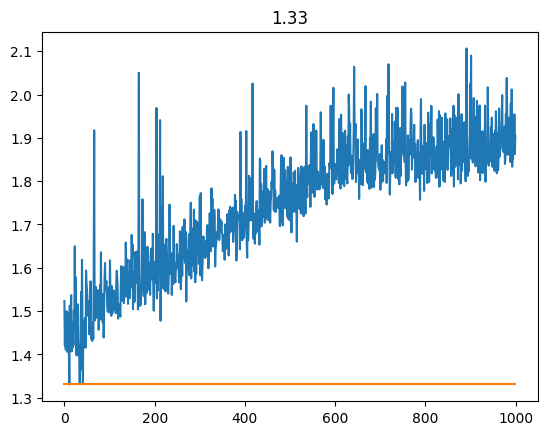

In [12]:
epochs = 1000
grad_clip = 5
MSE_min = np.Inf
MSE_accum = []
optimizer = torch.optim.RMSprop(model.parameters(), lr=3e-4)

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = []
    curr_loss1 = 0
    for iteration, data in enumerate(train_loader):
        _, measurement, location, motion = data
        batch_size, seq_len = motion.size(0), motion.size(1)
        measurement = ((measurement - measurement_mu) / measurement_std).to(device).float()
        motion = ((motion - motion_mu) / motion_std).to(device).float()
        location = location.to(device).float()
        model.zero_grad()
        loss, last_loss, pred, particle_pred = model.step(measurement, motion, location, 0.001)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        curr_loss1 += loss.to('cpu').detach().numpy() / len(train_numbers)
    train_loss.append(curr_loss1)

    model.eval()
    eval_loss = []
    curr_loss2 = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for iteration, data in enumerate(eval_loader):
            _, measurement, location, motion = data
            batch_size, seq_len = motion.size(0), motion.size(1)
            measurement = ((measurement - measurement_mu) / measurement_std).to(device).float()
            motion = ((motion - motion_mu) / motion_std).to(device).float()
            location = location.to(device).float()
            loss, last_loss, pred, particle_pred = model.step(measurement, motion, location, 0.001)
            curr_loss2 += loss.to('cpu').detach().numpy() / len(eval_numbers)
            y_true_curr = location[:, :, :2]
            y_pred_curr = torch.cat((pred[:, :, :1] * model.width, pred[:, :, 1:2] * model.height), dim=2)
            y_true.extend(y_true_curr.to('cpu').numpy())
            y_pred.extend(y_pred_curr.detach().to('cpu').numpy())

    eval_loss.append(curr_loss2)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = y_true.reshape(len(y_true), track_len, 2)
    y_pred = y_pred.reshape(len(y_pred), track_len, 2)

    X = (y_pred - y_true).reshape(y_pred.shape[0]*track_len, 2)
    MSE = (X**2).sum(axis=-1).mean()
    print('epoch, MSE', epoch, np.round(MSE, 3))
    if MSE < MSE_min:
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        filepath = "mbpfn_lab.ptm" 
        torch.save(state, filepath)
        MSE_min = MSE

    MSE_accum.append(MSE)

    clear_output(True)
    plt.figure()
    plt.title(str(np.round(MSE_min, 2)))
    plt.plot(MSE_accum)
    plt.plot([MSE_min]*(len(MSE_accum)))
    plt.show()

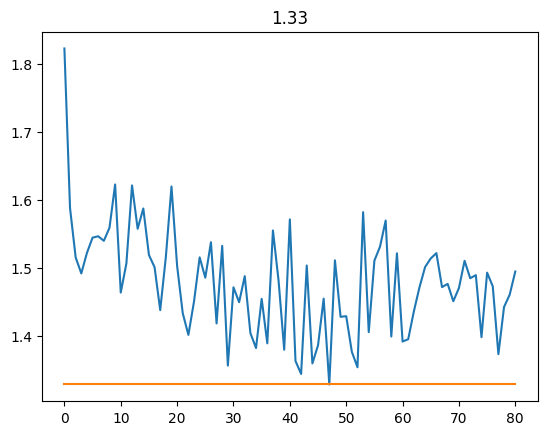

In [7]:
plt.figure()
plt.title(str(np.round(MSE_min, 2)))
plt.plot(MSE_accum)
plt.plot([MSE_min]*(len(MSE_accum)))
plt.show()

In [6]:
%%time
def load_checkpoint(filepath='mbpfn_lab.ptm'):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    print('epoch: ', checkpoint['epoch'])
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

model = MainModel(points).to(device).float()
model = load_checkpoint()

model.eval()
eval_loss = []
curr_loss2 = 0
y_pred = []
y_true = []
with torch.no_grad():
    for iteration, data in enumerate(test_loader):
        env_map, measurement, location, motion = data
        batch_size, seq_len = motion.size(0), motion.size(1)
        env_map = env_map.to(device).float()
        measurement = ((measurement - measurement_mu) / measurement_std).to(device).float()
        motion = ((motion - motion_mu) / motion_std).to(device).float()
        location = location.to(device).float()
        loss, last_loss, pred, particle_pred = model.step(measurement, motion, location, 0.1)
        curr_loss2 += loss.to('cpu').detach().numpy() / len(test_numbers)
        y_true_curr = location[:, :, :2]
        y_pred_curr = pred[:, :, :2]
        y_pred_curr[:, :, 0] *= model.width
        y_pred_curr[:, :, 1] *= model.height
        y_true.extend(y_true_curr.to('cpu').numpy())
        y_pred.extend(y_pred_curr.detach().to('cpu').numpy())

eval_loss.append(curr_loss2)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true = y_true.reshape(len(y_true), track_len, 2)
y_pred = y_pred.reshape(len(y_pred), track_len, 2)

X = (y_pred - y_true).reshape(y_pred.shape[0]*seq_len, 2)
MSE_arr = (X**2).sum(axis=-1)
Y = ((((y_pred - y_true)[:, -1])**2).sum(axis=-1)**0.5)
print('MSE mean and std, final point mean and std', MSE_arr.mean(), MSE_arr.std(), Y.mean(), Y.std())

epoch:  11
MSE mean and std, final point mean and std 1.3102986 9.799616 0.2448925 0.17497559
CPU times: user 3.31 s, sys: 132 ms, total: 3.44 s
Wall time: 3.33 s


/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-rkorkin2/code/Users/adm-RKorkin/paper2/pf_rnn.py:76: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  eps = torch.cuda.FloatTensor(std.shape).normal_()


In [5]:
Z = (((y_pred - y_true)**2).sum(-1)**0.5).mean(axis=0)
plt.plot(Z)
np.save('cl_pf_lab', Z)


In [6]:
#!g1.1


In [7]:
#!g1.1


In [8]:
#!g1.1


In [ ]:
#!g1.1
